# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Mon Mar 23 01:49:50 2020


In [5]:
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.models.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder
import src.train.train_model
%config IPCompleter.greedy=True
%reload_ext autoreload


In [6]:
%autoreload 2  # Autoreload all modules

In [7]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [8]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [9]:
import torch
print(torch.__version__)

1.4.0


In [6]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [7]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 64
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
64


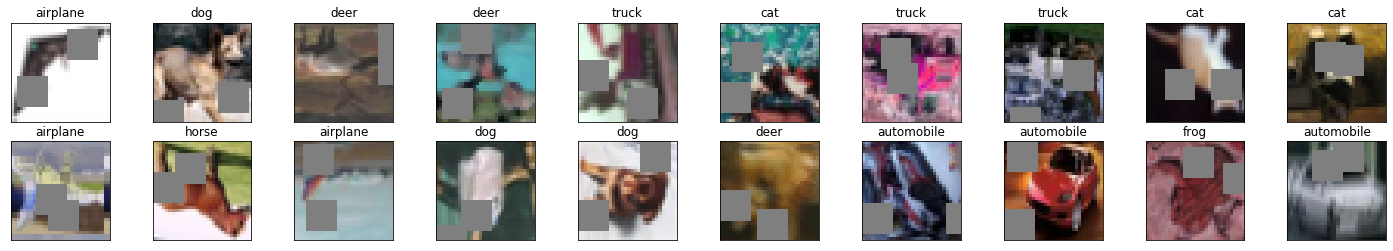

In [10]:
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



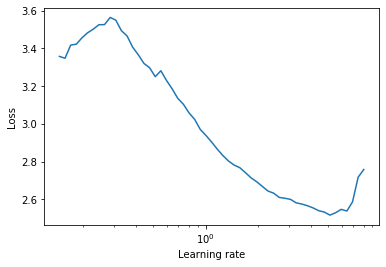

In [13]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


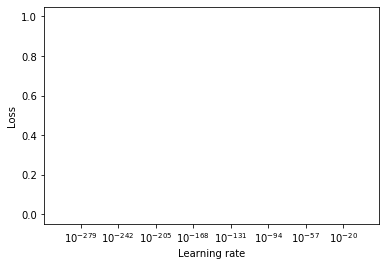

In [16]:
lr_finder.plot(skip_end=0)

In [17]:
lr_finder.reset()

In [18]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [19]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 75
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(cnn_model, device, test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.7895225286483765 Batch_id=781 Accuracy=26.76: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s]



Test set: Average loss: 0.0271, Accuracy: 3480/10000 (34.80%)

Validation accuracy increased (0.000000 --> 34.800000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  2
EPOCH: 2


Loss=1.445828914642334 Batch_id=781 Accuracy=36.38: 100%|██████████| 782/782 [02:50<00:00,  4.59it/s] 



Test set: Average loss: 0.0233, Accuracy: 4613/10000 (46.13%)

Validation accuracy increased (34.800000 --> 46.130000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  3
EPOCH: 3


Loss=2.842775583267212 Batch_id=781 Accuracy=40.97: 100%|██████████| 782/782 [02:59<00:00,  4.36it/s] 



Test set: Average loss: 0.0222, Accuracy: 4984/10000 (49.84%)

Validation accuracy increased (46.130000 --> 49.840000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  4
EPOCH: 4


Loss=1.4701485633850098 Batch_id=781 Accuracy=44.76: 100%|██████████| 782/782 [02:49<00:00,  4.62it/s]



Test set: Average loss: 0.0200, Accuracy: 5402/10000 (54.02%)

Validation accuracy increased (49.840000 --> 54.020000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  5
EPOCH: 5


Loss=1.4093345403671265 Batch_id=781 Accuracy=47.98: 100%|██████████| 782/782 [02:43<00:00,  4.78it/s]



Test set: Average loss: 0.0193, Accuracy: 5653/10000 (56.53%)

Validation accuracy increased (54.020000 --> 56.530000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  6
EPOCH: 6


Loss=1.2866580486297607 Batch_id=781 Accuracy=50.55: 100%|██████████| 782/782 [02:44<00:00,  4.76it/s]



Test set: Average loss: 0.0169, Accuracy: 6241/10000 (62.41%)

Validation accuracy increased (56.530000 --> 62.410000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  7
EPOCH: 7


Loss=1.2786880731582642 Batch_id=781 Accuracy=52.98: 100%|██████████| 782/782 [02:44<00:00,  4.76it/s]



Test set: Average loss: 0.0165, Accuracy: 6281/10000 (62.81%)

Validation accuracy increased (62.410000 --> 62.810000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  8
EPOCH: 8


Loss=0.6591535806655884 Batch_id=781 Accuracy=55.03: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s]



Test set: Average loss: 0.0151, Accuracy: 6612/10000 (66.12%)

Validation accuracy increased (62.810000 --> 66.120000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  9
EPOCH: 9


Loss=1.1197481155395508 Batch_id=781 Accuracy=56.90: 100%|██████████| 782/782 [02:40<00:00,  4.86it/s]



Test set: Average loss: 0.0145, Accuracy: 6745/10000 (67.45%)

Validation accuracy increased (66.120000 --> 67.450000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  10
EPOCH: 10


Loss=1.5652648210525513 Batch_id=781 Accuracy=58.29: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 6456/10000 (64.56%)

Learning rate = 0.06  for epoch:  11
EPOCH: 11


Loss=1.3787555694580078 Batch_id=781 Accuracy=60.21: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 6663/10000 (66.63%)

Learning rate = 0.06  for epoch:  12
EPOCH: 12


Loss=1.1236521005630493 Batch_id=781 Accuracy=61.61: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s]



Test set: Average loss: 0.0138, Accuracy: 6923/10000 (69.23%)

Validation accuracy increased (67.450000 --> 69.230000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  13
EPOCH: 13


Loss=0.721934974193573 Batch_id=781 Accuracy=62.88: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s] 



Test set: Average loss: 0.0116, Accuracy: 7450/10000 (74.50%)

Validation accuracy increased (69.230000 --> 74.500000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  14
EPOCH: 14


Loss=1.0539848804473877 Batch_id=781 Accuracy=64.69: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 7380/10000 (73.80%)

Learning rate = 0.06  for epoch:  15
EPOCH: 15


Loss=1.0756570100784302 Batch_id=781 Accuracy=65.89: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s]



Test set: Average loss: 0.0107, Accuracy: 7674/10000 (76.74%)

Validation accuracy increased (74.500000 --> 76.740000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  16
EPOCH: 16


Loss=0.5843720436096191 Batch_id=781 Accuracy=67.08: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]



Test set: Average loss: 0.0105, Accuracy: 7682/10000 (76.82%)

Validation accuracy increased (76.740000 --> 76.820000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  17
EPOCH: 17


Loss=1.3216323852539062 Batch_id=781 Accuracy=68.09: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s]



Test set: Average loss: 0.0104, Accuracy: 7739/10000 (77.39%)

Validation accuracy increased (76.820000 --> 77.390000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  18
EPOCH: 18


Loss=0.34534159302711487 Batch_id=781 Accuracy=68.99: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]



Test set: Average loss: 0.0100, Accuracy: 7766/10000 (77.66%)

Validation accuracy increased (77.390000 --> 77.660000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  19
EPOCH: 19


Loss=0.7399306297302246 Batch_id=781 Accuracy=69.79: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s]



Test set: Average loss: 0.0101, Accuracy: 7811/10000 (78.11%)

Validation accuracy increased (77.660000 --> 78.110000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  20
EPOCH: 20


Loss=1.3167961835861206 Batch_id=781 Accuracy=70.79: 100%|██████████| 782/782 [02:36<00:00,  4.98it/s]



Test set: Average loss: 0.0098, Accuracy: 7903/10000 (79.03%)

Validation accuracy increased (78.110000 --> 79.030000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  21
EPOCH: 21


Loss=0.5370683670043945 Batch_id=781 Accuracy=71.56: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s] 



Test set: Average loss: 0.0094, Accuracy: 7987/10000 (79.87%)

Validation accuracy increased (79.030000 --> 79.870000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  22
EPOCH: 22


Loss=0.5937349796295166 Batch_id=781 Accuracy=72.64: 100%|██████████| 782/782 [02:38<00:00,  4.93it/s] 



Test set: Average loss: 0.0087, Accuracy: 8082/10000 (80.82%)

Validation accuracy increased (79.870000 --> 80.820000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  23
EPOCH: 23


Loss=0.9554447531700134 Batch_id=781 Accuracy=73.44: 100%|██████████| 782/782 [02:36<00:00,  4.98it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 8056/10000 (80.56%)

Learning rate = 0.06  for epoch:  24
EPOCH: 24


Loss=0.6789590716362 Batch_id=781 Accuracy=73.87: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s]    



Test set: Average loss: 0.0080, Accuracy: 8245/10000 (82.45%)

Validation accuracy increased (80.820000 --> 82.450000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  25
EPOCH: 25


Loss=0.5548429489135742 Batch_id=781 Accuracy=74.45: 100%|██████████| 782/782 [02:36<00:00,  4.98it/s] 



Test set: Average loss: 0.0080, Accuracy: 8294/10000 (82.94%)

Validation accuracy increased (82.450000 --> 82.940000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  26
EPOCH: 26


Loss=0.8564134836196899 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [02:39<00:00,  4.92it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8292/10000 (82.92%)

Learning rate = 0.06  for epoch:  27
EPOCH: 27


Loss=0.4025753140449524 Batch_id=781 Accuracy=75.48: 100%|██████████| 782/782 [02:36<00:00,  5.00it/s] 



Test set: Average loss: 0.0076, Accuracy: 8370/10000 (83.70%)

Validation accuracy increased (82.940000 --> 83.700000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  28
EPOCH: 28


Loss=1.0552746057510376 Batch_id=781 Accuracy=76.25: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8320/10000 (83.20%)

Learning rate = 0.06  for epoch:  29
EPOCH: 29


Loss=0.49698376655578613 Batch_id=781 Accuracy=76.49: 100%|██████████| 782/782 [02:38<00:00,  4.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8284/10000 (82.84%)

Learning rate = 0.06  for epoch:  30
EPOCH: 30


Loss=0.5628350377082825 Batch_id=781 Accuracy=77.28: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s] 



Test set: Average loss: 0.0073, Accuracy: 8408/10000 (84.08%)

Validation accuracy increased (83.700000 --> 84.080000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 5.4000e-02.
Learning rate = 0.054  for epoch:  31
EPOCH: 31


Loss=1.0221809148788452 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s] 



Test set: Average loss: 0.0069, Accuracy: 8513/10000 (85.13%)

Validation accuracy increased (84.080000 --> 85.130000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.054  for epoch:  32
EPOCH: 32


Loss=0.677915096282959 Batch_id=781 Accuracy=78.23: 100%|██████████| 782/782 [02:37<00:00,  4.97it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8490/10000 (84.90%)

Learning rate = 0.054  for epoch:  33
EPOCH: 33


Loss=0.4980638325214386 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8500/10000 (85.00%)

Learning rate = 0.054  for epoch:  34
EPOCH: 34


Loss=0.7115198969841003 Batch_id=781 Accuracy=78.98: 100%|██████████| 782/782 [02:37<00:00,  4.96it/s] 



Test set: Average loss: 0.0069, Accuracy: 8587/10000 (85.87%)

Validation accuracy increased (85.130000 --> 85.870000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 4.8600e-02.
Learning rate = 0.0486  for epoch:  35
EPOCH: 35


Loss=0.510564923286438 Batch_id=781 Accuracy=79.91: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s]  



Test set: Average loss: 0.0066, Accuracy: 8590/10000 (85.90%)

Validation accuracy increased (85.870000 --> 85.900000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  36
EPOCH: 36


Loss=0.6456056237220764 Batch_id=781 Accuracy=79.97: 100%|██████████| 782/782 [02:33<00:00,  5.11it/s] 



Test set: Average loss: 0.0067, Accuracy: 8604/10000 (86.04%)

Validation accuracy increased (85.900000 --> 86.040000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  37
EPOCH: 37


Loss=0.5268986821174622 Batch_id=781 Accuracy=80.60: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8582/10000 (85.82%)

Learning rate = 0.0486  for epoch:  38
EPOCH: 38


Loss=0.5421029329299927 Batch_id=781 Accuracy=80.77: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s] 



Test set: Average loss: 0.0063, Accuracy: 8672/10000 (86.72%)

Validation accuracy increased (86.040000 --> 86.720000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  39
EPOCH: 39


Loss=0.6012175679206848 Batch_id=781 Accuracy=81.23: 100%|██████████| 782/782 [02:38<00:00,  4.93it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8627/10000 (86.27%)

Epoch    39: reducing learning rate of group 0 to 4.3740e-02.
Learning rate = 0.04374  for epoch:  40
EPOCH: 40


Loss=0.5399377346038818 Batch_id=781 Accuracy=82.03: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 



Test set: Average loss: 0.0062, Accuracy: 8672/10000 (86.72%)

Validation accuracy increased (86.720000 --> 86.720000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.04374  for epoch:  41
EPOCH: 41


Loss=0.37589097023010254 Batch_id=781 Accuracy=81.84: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s]



Test set: Average loss: 0.0062, Accuracy: 8719/10000 (87.19%)

Validation accuracy increased (86.720000 --> 87.190000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.04374  for epoch:  42
EPOCH: 42


Loss=0.981492817401886 Batch_id=781 Accuracy=82.31: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8686/10000 (86.86%)

Learning rate = 0.04374  for epoch:  43
EPOCH: 43


Loss=0.7438024282455444 Batch_id=781 Accuracy=82.37: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8680/10000 (86.80%)

Learning rate = 0.04374  for epoch:  44
EPOCH: 44


Loss=0.3615216612815857 Batch_id=781 Accuracy=82.90: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8636/10000 (86.36%)

Epoch    44: reducing learning rate of group 0 to 3.9366e-02.
Learning rate = 0.039366000000000005  for epoch:  45
EPOCH: 45


Loss=0.9419465065002441 Batch_id=781 Accuracy=83.40: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s] 



Test set: Average loss: 0.0058, Accuracy: 8773/10000 (87.73%)

Validation accuracy increased (87.190000 --> 87.730000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  46
EPOCH: 46


Loss=0.5543957948684692 Batch_id=781 Accuracy=83.34: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s] 



Test set: Average loss: 0.0058, Accuracy: 8794/10000 (87.94%)

Validation accuracy increased (87.730000 --> 87.940000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  47
EPOCH: 47


Loss=0.5175637006759644 Batch_id=781 Accuracy=83.82: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8782/10000 (87.82%)

Epoch    47: reducing learning rate of group 0 to 3.5429e-02.
Learning rate = 0.03542940000000001  for epoch:  48
EPOCH: 48


Loss=0.19951701164245605 Batch_id=781 Accuracy=84.37: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s]



Test set: Average loss: 0.0058, Accuracy: 8815/10000 (88.15%)

Validation accuracy increased (87.940000 --> 88.150000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.03542940000000001  for epoch:  49
EPOCH: 49


Loss=0.2937169075012207 Batch_id=781 Accuracy=84.68: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8801/10000 (88.01%)

Learning rate = 0.03542940000000001  for epoch:  50
EPOCH: 50


Loss=0.3640536963939667 Batch_id=781 Accuracy=84.76: 100%|██████████| 782/782 [02:40<00:00,  4.86it/s] 



Test set: Average loss: 0.0057, Accuracy: 8837/10000 (88.37%)

Validation accuracy increased (88.150000 --> 88.370000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.03542940000000001  for epoch:  51
EPOCH: 51


Loss=0.6841171979904175 Batch_id=781 Accuracy=85.03: 100%|██████████| 782/782 [02:40<00:00,  4.89it/s] 



Test set: Average loss: 0.0057, Accuracy: 8846/10000 (88.46%)

Validation accuracy increased (88.370000 --> 88.460000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    51: reducing learning rate of group 0 to 3.1886e-02.
Learning rate = 0.031886460000000005  for epoch:  52
EPOCH: 52


Loss=0.3598710000514984 Batch_id=781 Accuracy=85.44: 100%|██████████| 782/782 [02:38<00:00,  4.92it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8842/10000 (88.42%)

Learning rate = 0.031886460000000005  for epoch:  53
EPOCH: 53


Loss=0.639218807220459 Batch_id=781 Accuracy=85.45: 100%|██████████| 782/782 [02:43<00:00,  4.80it/s]  
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8783/10000 (87.83%)

Learning rate = 0.031886460000000005  for epoch:  54
EPOCH: 54


Loss=0.7166283130645752 Batch_id=781 Accuracy=85.66: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8841/10000 (88.41%)

Epoch    54: reducing learning rate of group 0 to 2.8698e-02.
Learning rate = 0.028697814000000006  for epoch:  55
EPOCH: 55


Loss=0.35251495242118835 Batch_id=781 Accuracy=86.30: 100%|██████████| 782/782 [02:39<00:00,  4.91it/s]



Test set: Average loss: 0.0056, Accuracy: 8857/10000 (88.57%)

Validation accuracy increased (88.460000 --> 88.570000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.028697814000000006  for epoch:  56
EPOCH: 56


Loss=0.7477174401283264 Batch_id=781 Accuracy=86.48: 100%|██████████| 782/782 [02:35<00:00,  5.04it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8828/10000 (88.28%)

Learning rate = 0.028697814000000006  for epoch:  57
EPOCH: 57


Loss=0.5721176266670227 Batch_id=781 Accuracy=86.52: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s] 



Test set: Average loss: 0.0056, Accuracy: 8863/10000 (88.63%)

Validation accuracy increased (88.570000 --> 88.630000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch    57: reducing learning rate of group 0 to 2.5828e-02.
Learning rate = 0.025828032600000005  for epoch:  58
EPOCH: 58


Loss=0.573361337184906 Batch_id=781 Accuracy=86.87: 100%|██████████| 782/782 [02:32<00:00,  5.14it/s]  



Test set: Average loss: 0.0054, Accuracy: 8896/10000 (88.96%)

Validation accuracy increased (88.630000 --> 88.960000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.025828032600000005  for epoch:  59
EPOCH: 59


Loss=0.22929053008556366 Batch_id=781 Accuracy=87.11: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8874/10000 (88.74%)

Learning rate = 0.025828032600000005  for epoch:  60
EPOCH: 60


Loss=0.3492332994937897 Batch_id=781 Accuracy=87.04: 100%|██████████| 782/782 [02:41<00:00,  4.83it/s] 



Test set: Average loss: 0.0055, Accuracy: 8921/10000 (89.21%)

Validation accuracy increased (88.960000 --> 89.210000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.025828032600000005  for epoch:  61
EPOCH: 61


Loss=0.12904134392738342 Batch_id=781 Accuracy=87.33: 100%|██████████| 782/782 [02:40<00:00,  4.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8908/10000 (89.08%)

Learning rate = 0.025828032600000005  for epoch:  62
EPOCH: 62


Loss=0.2727847099304199 Batch_id=781 Accuracy=87.66: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s] 



Test set: Average loss: 0.0054, Accuracy: 8925/10000 (89.25%)

Validation accuracy increased (89.210000 --> 89.250000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.025828032600000005  for epoch:  63
EPOCH: 63


Loss=0.26149648427963257 Batch_id=781 Accuracy=87.33: 100%|██████████| 782/782 [02:39<00:00,  4.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8913/10000 (89.13%)

Epoch    63: reducing learning rate of group 0 to 2.3245e-02.
Learning rate = 0.023245229340000007  for epoch:  64
EPOCH: 64


Loss=0.36556097865104675 Batch_id=781 Accuracy=87.81: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s]



Test set: Average loss: 0.0053, Accuracy: 8939/10000 (89.39%)

Validation accuracy increased (89.250000 --> 89.390000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.023245229340000007  for epoch:  65
EPOCH: 65


Loss=0.38864415884017944 Batch_id=781 Accuracy=87.98: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8894/10000 (88.94%)

Learning rate = 0.023245229340000007  for epoch:  66
EPOCH: 66


Loss=0.3127579391002655 Batch_id=781 Accuracy=88.26: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8885/10000 (88.85%)

Epoch    66: reducing learning rate of group 0 to 2.0921e-02.
Learning rate = 0.020920706406000005  for epoch:  67
EPOCH: 67


Loss=0.3462364673614502 Batch_id=781 Accuracy=88.74: 100%|██████████| 782/782 [02:41<00:00,  4.84it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8877/10000 (88.77%)

Learning rate = 0.020920706406000005  for epoch:  68
EPOCH: 68


Loss=0.2529720366001129 Batch_id=781 Accuracy=88.64: 100%|██████████| 782/782 [02:38<00:00,  4.93it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8920/10000 (89.20%)

Learning rate = 0.020920706406000005  for epoch:  69
EPOCH: 69


Loss=0.20536279678344727 Batch_id=781 Accuracy=88.88: 100%|██████████| 782/782 [03:34<00:00,  3.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8878/10000 (88.78%)

Epoch    69: reducing learning rate of group 0 to 1.8829e-02.
Learning rate = 0.018828635765400004  for epoch:  70
EPOCH: 70


Loss=0.3775922358036041 Batch_id=781 Accuracy=89.19: 100%|██████████| 782/782 [02:17<00:00,  5.69it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8927/10000 (89.27%)

Learning rate = 0.018828635765400004  for epoch:  71
EPOCH: 71


Loss=0.37196874618530273 Batch_id=781 Accuracy=89.22: 100%|██████████| 782/782 [02:35<00:00,  5.02it/s]



Test set: Average loss: 0.0052, Accuracy: 8987/10000 (89.87%)

Validation accuracy increased (89.390000 --> 89.870000).  Saving model ...


  0%|          | 0/782 [00:00<?, ?it/s]

Learning rate = 0.018828635765400004  for epoch:  72
EPOCH: 72


Loss=0.25007081031799316 Batch_id=781 Accuracy=89.61: 100%|██████████| 782/782 [02:36<00:00,  4.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8959/10000 (89.59%)

Epoch    72: reducing learning rate of group 0 to 1.6946e-02.
Learning rate = 0.016945772188860005  for epoch:  73
EPOCH: 73


Loss=0.3399163782596588 Batch_id=781 Accuracy=89.47: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s] 
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8982/10000 (89.82%)

Learning rate = 0.016945772188860005  for epoch:  74
EPOCH: 74


Loss=0.19569632411003113 Batch_id=781 Accuracy=89.63: 100%|██████████| 782/782 [02:36<00:00,  5.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8980/10000 (89.80%)

Learning rate = 0.016945772188860005  for epoch:  75
EPOCH: 75


Loss=0.09617164731025696 Batch_id=781 Accuracy=89.71: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s]



Test set: Average loss: 0.0052, Accuracy: 8987/10000 (89.87%)

Validation accuracy increased (89.870000 --> 89.870000).  Saving model ...
Epoch    75: reducing learning rate of group 0 to 1.5251e-02.
Learning rate = 0.015251194969974005  for epoch:  76


In [20]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

In [1]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import ModelUtils
import src.visualization.plotdata as plotdata
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.customcompose as customcompose

In [2]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

True


In [3]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

cuda


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
64


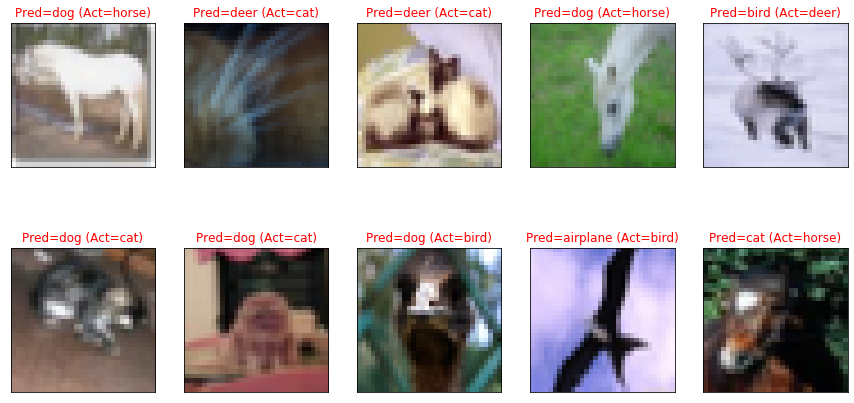

In [4]:
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

batch_size = 64
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
test_loader = dataloader.gettestdataloader()

# obtain one batch of test images
dataiterator = iter(test_loader)
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()
plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=model,classes=classes,
                                          batch_size=batch_size,dogradcam=False)

In [5]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 83% (9755/11732)
Test Accuracy of automobile: 90% (10762/11873)
Test Accuracy of  bird: 73% (8633/11789)
Test Accuracy of   cat: 64% (7575/11669)
Test Accuracy of  deer: 79% (9352/11803)
Test Accuracy of   dog: 71% (8493/11815)
Test Accuracy of  frog: 88% (10423/11813)
Test Accuracy of horse: 84% (9952/11754)
Test Accuracy of  ship: 89% (10592/11874)
Test Accuracy of truck: 87% (10201/11628)

Test Accuracy (Overall): 81% (95738/117750)


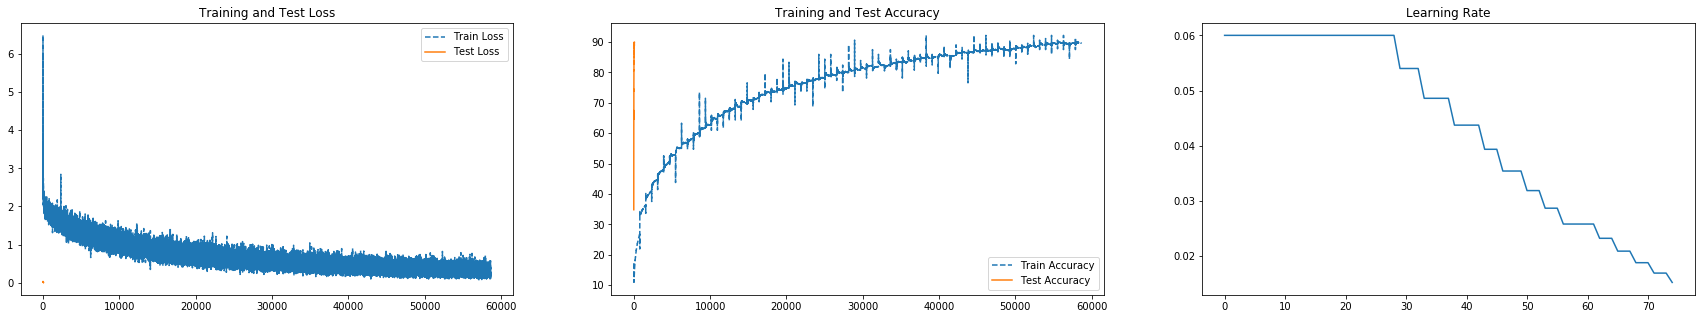

In [6]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True)

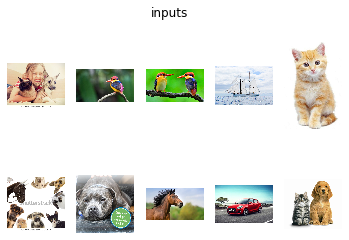

In [7]:
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
ModelUtils.subplot(images, title='inputs', nrows=2, ncols=5)

In [8]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

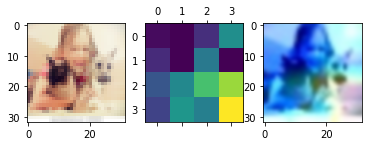

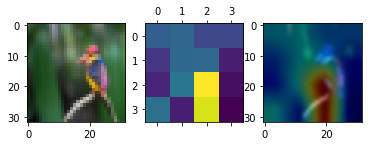

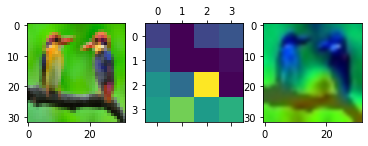

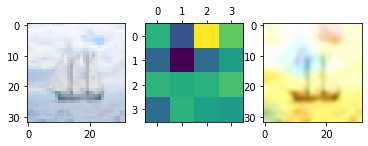

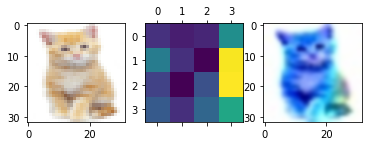

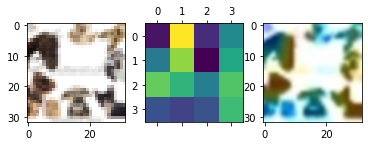

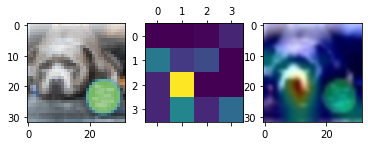

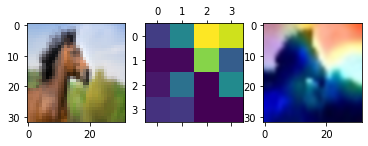

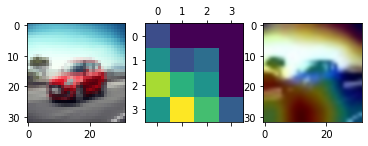

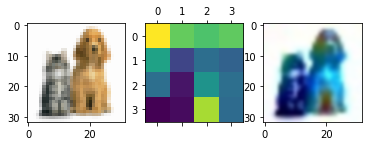

In [9]:
from src.visualization.gradcam.gradcam import gradcamof

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

gradcamof(model,inputs,classes)